# Simple model using Stable Diffusion and OpenCV

## Overview of the Method

This approach consists of two main functionalities:

1. **Image Generation**  
   Convert a description into an image using **Stable Diffusion**.

2. **SVG Conversion**  
   Convert the generated image into an **SVG format** using **OpenCV**.

In [1]:
#| default_exp core

In [2]:
#| export
import kagglehub

import concurrent
import io
import os
import cv2
import numpy as np
import torch
from diffusers import StableDiffusionPipeline, DDIMScheduler
from tqdm import tqdm
import pandas as pd
from io import BytesIO
import math
from lxml import etree
import logging

# Set up device
device = "cuda:1" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

2025-05-04 08:15:46.554497: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746346546.809336      25 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746346546.882356      25 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Using device: cpu


## Image Generation

In [3]:
#| export

# Load Stable Diffusion pipeline
stable_diffusion_path = kagglehub.model_download("stabilityai/stable-diffusion-v2/pytorch/1/1")
scheduler = DDIMScheduler.from_pretrained(stable_diffusion_path, subfolder="scheduler")
pipeline = StableDiffusionPipeline.from_pretrained(
        stable_diffusion_path,
        scheduler=scheduler,
        torch_dtype=torch.float16 if device == "cuda" else torch.float32,
        safety_checker=None   # Disable safety checker for speed
    )
pipeline.to(device)
print("Stable Diffusion model loaded successfully")


def generate_image(prompt, height=512, width=512, num_inference_steps=25, guidance_scale=12):
    """
    Generate an image using Stable Diffusion
        
    Args:
        prompt (str): Text description for image generation
        height (int): Height of the output image
        width (int): Width of the output image
        num_inference_steps (int): Number of denoising steps
            
    Returns:
        PIL.Image.Image: Generated image as a PIL image
    """
    # logging.debug('Generating image for prompt: %s', prompt)
        
    # Generate image
    image = pipeline(
        prompt, 
        height=height, 
        width=width,
        num_inference_steps=num_inference_steps,
        guidance_scale=guidance_scale
    ).images[0]
        
    return image

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

Stable Diffusion model loaded successfully


### Let's try using Stable Diffusion with a simple example.

  0%|          | 0/25 [00:00<?, ?it/s]

<class 'PIL.Image.Image'>


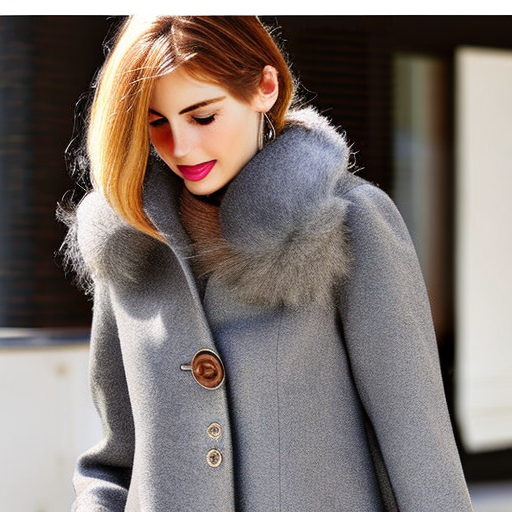

In [4]:
prompt = "gray wool coat with a faux fur collar"
image = generate_image(prompt)
print(type(image))
image

## SVG Conversion

In [5]:
#| export

# Setting
default_svg= """<svg width="256" height="256" viewBox="0 0 256 256"><circle cx="50" cy="50" r="40" fill="red" /></svg>"""
svg_constraints = kagglehub.package_import('metric/svg-constraints')
constraints = svg_constraints.SVGConstraints()

In [6]:
#| export

def compress_hex_color(hex_color):
    """Convert hex color to shortest possible representation"""
    r, g, b = int(hex_color[1:3], 16), int(hex_color[3:5], 16), int(hex_color[5:7], 16)
    if r % 17 == 0 and g % 17 == 0 and b % 17 == 0:
        return f'#{r//17:x}{g//17:x}{b//17:x}'
    return hex_color

def extract_features_by_scale(img_np, num_colors=12):
    """
    Extract image features hierarchically by scale
        
    Args:
        img_np (np.ndarray): Input image
        num_colors (int): Number of colors to quantize
        
    Returns:
        list: Hierarchical features sorted by importance
    """
    
    # Convert to RGB if needed
    if len(img_np.shape) == 3 and img_np.shape[2] > 1:
        img_rgb = img_np
    else:
        img_rgb = cv2.cvtColor(img_np, cv2.COLOR_GRAY2RGB)
        
    # Convert to grayscale for processing
    gray = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2GRAY)
    height, width = gray.shape
        
    # Perform color quantization
    pixels = img_rgb.reshape(-1, 3).astype(np.float32)
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.2)
    _, labels, centers = cv2.kmeans(pixels, num_colors, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)

    # Quantized image
    palette = centers.astype(np.uint8)
    quantized = palette[labels.flatten()].reshape(img_rgb.shape)
        
    # Hierarchical feature extraction
    hierarchical_features = []
        
    # Sort colors by frequency
    unique_labels, counts = np.unique(labels, return_counts=True)
    sorted_indices = np.argsort(-counts)
    sorted_colors = [palette[i] for i in sorted_indices]
        
    # Center point for importance calculations
    center_x, center_y = width/2, height/2
        
    for color in sorted_colors:
        # Create color mask
        color_mask = cv2.inRange(quantized, color, color)
            
        # Find contours
        contours, _ = cv2.findContours(color_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
            
        # Sort contours by area (largest first)
        contours = sorted(contours, key=cv2.contourArea, reverse=True)
            
        # Convert RGB to compressed hex
        hex_color = compress_hex_color(f'#{color[0]:02x}{color[1]:02x}{color[2]:02x}')
            
        color_features = []
        for contour in contours:
            # Skip tiny contours
            area = cv2.contourArea(contour)
            if area < 20:
                continue
                
            # Calculate contour center
            m = cv2.moments(contour)
            if m["m00"] == 0:
                continue
                    
            cx = int(m["m10"] / m["m00"])
            cy = int(m["m01"] / m["m00"])
                
            # Distance from image center (normalized)
            dist_from_center = np.sqrt(((cx - center_x) / width)**2 + ((cy - center_y) / height)**2)
                
            # Simplify contour
            epsilon = 0.02 * cv2.arcLength(contour, True)
            approx = cv2.approxPolyDP(contour, epsilon, True)
                
            # Generate points string
            points = " ".join([f"{pt[0][0]:.1f},{pt[0][1]:.1f}" for pt in approx])
        
            # Calculate importance (area, proximity to center, complexity)
            importance = (
                area * 
                (1 - dist_from_center) * 
                (1 / (len(approx) + 1))
            )
                
            color_features.append({
                'points': points,
                'color': hex_color,
                'area': area,
                'importance': importance
            })
    
        # Sort features by importance within this color
        color_features.sort(key=lambda x: x['importance'], reverse=True)
        hierarchical_features.extend(color_features)
    
    # Final sorting by overall importance
    hierarchical_features.sort(key=lambda x: x['importance'], reverse=True)
        
    return hierarchical_features

def bitmap_to_svg_layered(image, max_size_bytes=10000, resize=True, target_size=(256, 256)):
    """
    Convert bitmap to SVG using layered feature extraction
        
    Args:
        image: Input image (PIL.Image)
        max_size_bytes (int): Maximum SVG size
        resize (bool): Whether to resize the image before processing
        target_size (tuple): Target size for resizing (width, height)
        
    Returns:
        str: SVG representation
    """
    # Resize the image if requested
    if resize:
        original_size = image.size
        image = image.resize(target_size, Image.LANCZOS)
    else:
        original_size = image.size
        
    # Convert to numpy array
    img_np = np.array(image)
        
    # Get image dimensions
    height, width = img_np.shape[:2]
        
    # Calculate average background color
    if len(img_np.shape) == 3 and img_np.shape[2] == 3:
        avg_bg_color = np.mean(img_np, axis=(0,1)).astype(int)
        bg_hex_color = compress_hex_color(f'#{avg_bg_color[0]:02x}{avg_bg_color[1]:02x}{avg_bg_color[2]:02x}')
    else:
        bg_hex_color = '#fff'
        
    # Start building SVG
    # Use original dimensions in viewBox for proper scaling when displayed
    orig_width, orig_height = original_size
    svg = f'<svg xmlns="http://www.w3.org/2000/svg" width="{orig_width}" height="{orig_height}" viewBox="0 0 {width} {height}">'
    svg += f'<rect width="{width}" height="{height}" fill="{bg_hex_color}"/>'
        
    # Extract hierarchical features
    features = extract_features_by_scale(img_np)

    # Add features layer by layer
    for feature in features:
        # Try adding the feature
        temp_svg = svg + f'<polygon points="{feature["points"]}" fill="{feature["color"]}"/></svg>'
            
        # Check if adding this feature exceeds size limit
        if len(temp_svg.encode('utf-8')) > max_size_bytes:
            break
            
        # Add the feature
        svg += f'<polygon points="{feature["points"]}" fill="{feature["color"]}"/>'
        
    # Close SVG
    svg += '</svg>'
            
        
    # Final size check
    if len(svg.encode('utf-8')) > max_size_bytes:
        return f'<svg xmlns="http://www.w3.org/2000/svg" viewBox="0 0 {width} {height}"><rect width="{width}" height="{height}" fill="{bg_hex_color}"/></svg>'
        
    return svg

### SVG Modification

Since there are constraints on the SVG images required for this competition, we will modify the SVG image obtained from the previous function to meet those constraints.

In [7]:
#| export

def enforce_constraints(svg_string):
    """Enforces constraints on an SVG string, removing disallowed elements and attributes.

    Args:
        svg_string : str 
            The SVG string to process.

    Returns:
        svg_string : str
            The processed SVG string, or the default SVG if constraints
            cannot be satisfied.
    """
    # logging.info('Sanitizing SVG...')

    try:
        parser = etree.XMLParser(remove_blank_text=True, remove_comments=True)
        root = etree.fromstring(svg_string, parser=parser)
    except etree.ParseError as e:
        logging.error('SVG Parse Error: %s. Returning default SVG.', e)
        return default_svg
    
    elements_to_remove = []
    for element in root.iter():
        tag_name = etree.QName(element.tag).localname
    
        # Remove disallowed elements
        if tag_name not in constraints.allowed_elements:
            elements_to_remove.append(element)
            continue  # Skip attribute checks for removed elements
    
        # Remove disallowed attributes
        attrs_to_remove = []
        for attr in element.attrib:
            attr_name = etree.QName(attr).localname
            if (
                attr_name
                not in constraints.allowed_elements[tag_name]
                and attr_name
                not in constraints.allowed_elements['common']
            ):
                attrs_to_remove.append(attr)
    
        for attr in attrs_to_remove:
            logging.debug(
                'Attribute "%s" for element "%s" not allowed. Removing.',
                attr,
                tag_name,
            )
            del element.attrib[attr]
    
        # Check and remove invalid href attributes
        for attr, value in element.attrib.items():
            if etree.QName(attr).localname == 'href' and not value.startswith('#'):
                logging.debug(
                    'Removing invalid href attribute in element "%s".', tag_name
                )
                del element.attrib[attr]

        # Validate path elements to help ensure SVG conversion
        if tag_name == 'path':
            d_attribute = element.get('d')
            if not d_attribute:
                logging.warning('Path element is missing "d" attribute. Removing path.')
                elements_to_remove.append(element)
                continue # Skip further checks for this removed element
            # Use regex to validate 'd' attribute format
            path_regex = re2.compile(
                r'^'  # Start of string
                r'(?:'  # Non-capturing group for each command + numbers block
                r'[MmZzLlHhVvCcSsQqTtAa]'  # Valid SVG path commands (adjusted to exclude extra letters)
                r'\s*'  # Optional whitespace after command
                r'(?:'  # Non-capturing group for optional numbers
                r'-?\d+(?:\.\d+)?(?:[Ee][+-]?\d+)?'  # First number
                r'(?:[\s,]+-?\d+(?:\.\d+)?(?:[Ee][+-]?\d+)?)*'  # Subsequent numbers with mandatory separator(s)
                r')?'  # Numbers are optional (e.g. for Z command)
                r'\s*'  # Optional whitespace after numbers/command block
                r')+'  # One or more command blocks
                r'\s*'  # Optional trailing whitespace
                r'$'  # End of string
            )
            if not path_regex.match(d_attribute):
                logging.warning(
                    'Path element has malformed "d" attribute format. Removing path.'
                )
                elements_to_remove.append(element)
                continue
            logging.debug('Path element "d" attribute validated (regex check).')
        
    # Remove elements marked for removal
    for element in elements_to_remove:
        if element.getparent() is not None:
            element.getparent().remove(element)
            logging.debug('Removed element: %s', element.tag)

    try:
        cleaned_svg_string = etree.tostring(root, encoding='unicode')
        return cleaned_svg_string
    except ValueError as e:
        logging.error(
            'SVG could not be sanitized to meet constraints: %s', e
        )
        return default_svg

## SD model

In [8]:
# #| export

# class Model:
#     def __init__(self):
#         """
#         Initialize the pipeline with Stable Diffusion model
        
#         Args:
#             sd_model (str): Stable Diffusion model ID to load
#         """

#     def predict(self, description: str) -> str:
#         """
#         Process a prompt through the full pipeline
        
#         Args:
#             prompt (str): Text description
            
#         Returns:
#             dict: Dictionary containing paths to outputs and the SVG string
#         """
#         self.prefix = ""
#         self.suffix = ""
        
#         try:
#             prompt = self.prefix + description + self.suffix
#             img = generate_image(prompt)
            
#             # Convert to SVG
#             svg = bitmap_to_svg_layered(img)
#             del img
#             if torch.cuda.is_available():
#                 torch.cuda.empty_cache()
#             # logging.debug('Unprocessed SVG: %s', svg)
#             # svg = enforce_constraints(svg)
#             # logging.debug('Processed SVG: %s', svg)
#             # Ensure the generated code can be converted by cairosvg
#             # cairosvg.svg2png(bytestring=svg.encode('utf-8'))
#             return svg
                
#         except Exception as e:
#             logging.error('Exception during SVG generation: %s', e)
#             return default_svg

In [9]:
#| export

class Model:
    def __init__(self):
        """
        Initialize the pipeline with Stable Diffusion model
        
        Args:
            sd_model (str): Stable Diffusion model ID to load
        """

    def predict(self, description: str) -> str:
        """
        Process a prompt through the full pipeline
        
        Args:
            prompt (str): Text description
            
        Returns:
            dict: Dictionary containing paths to outputs and the SVG string
        """
        self.prefix = ""
        self.suffix = ""
        

        prompt = self.prefix + description + self.suffix
        img = generate_image(prompt)
            
        # Convert to SVG
        svg = bitmap_to_svg_layered(img)
        del img
        if torch.cuda.is_available():
            torch.cuda.empty_cache()
            # logging.debug('Unprocessed SVG: %s', svg)
            # svg = enforce_constraints(svg)
            # logging.debug('Processed SVG: %s', svg)
            # Ensure the generated code can be converted by cairosvg
            # cairosvg.svg2png(bytestring=svg.encode('utf-8'))
        return svg

## Test

In [10]:
import kaggle_evaluation

logging.basicConfig(level=logging.INFO, force=True)
kaggle_evaluation.test(Model)

Creating Model instance...
Running inference tests...
Wrote test submission file to "/tmp/kaggle-evaluation-submission-abys3uwb.csv".
Success!


In [11]:
import cairosvg
from PIL import Image
import matplotlib.pyplot as plt

def svg_to_png(svg_code: str, size: tuple = (384, 384)) -> Image.Image:
    """
    Converts an SVG string to a PNG image using CairoSVG.

    If the SVG does not define a `viewBox`, it will add one using the provided size.

    Parameters
    ----------
    svg_code : str
        The SVG string to convert.
    size : tuple[int, int], default=(384, 384)
        The desired size of the output PNG image (width, height).

    Returns
    -------
    PIL.Image.Image
        The generated PNG image.
    """
    # Ensure SVG has proper size attributes
    if 'viewBox' not in svg_code:
        svg_code = svg_code.replace('<svg', f'<svg viewBox="0 0 {size[0]} {size[1]}"')

    # Convert SVG to PNG
    png_data = cairosvg.svg2png(bytestring=svg_code.encode('utf-8'))
    return Image.open(io.BytesIO(png_data)).convert('RGB').resize(size)

  0%|          | 0/25 [00:00<?, ?it/s]

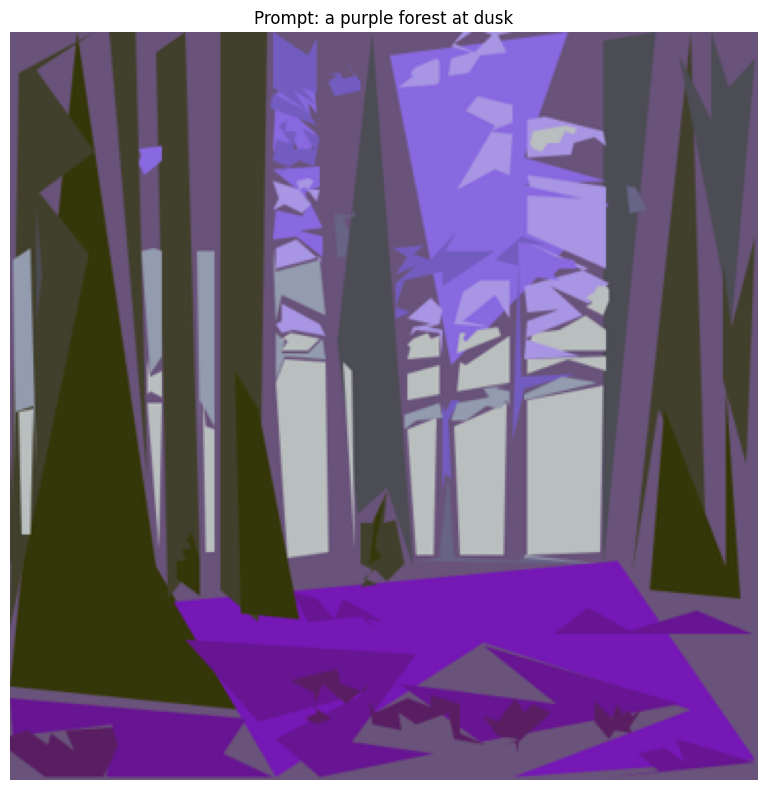

  0%|          | 0/25 [00:00<?, ?it/s]

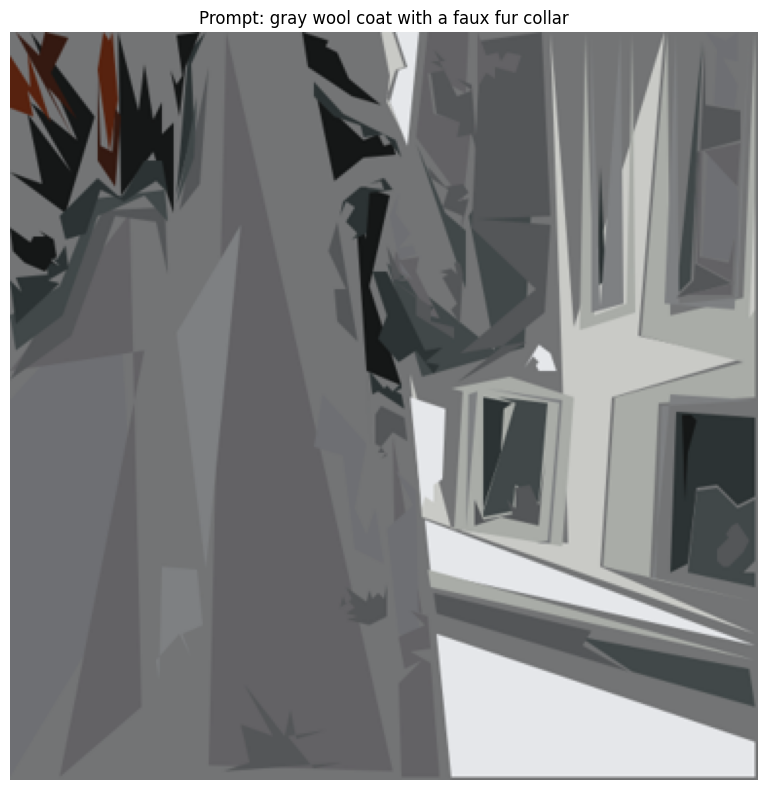

  0%|          | 0/25 [00:00<?, ?it/s]

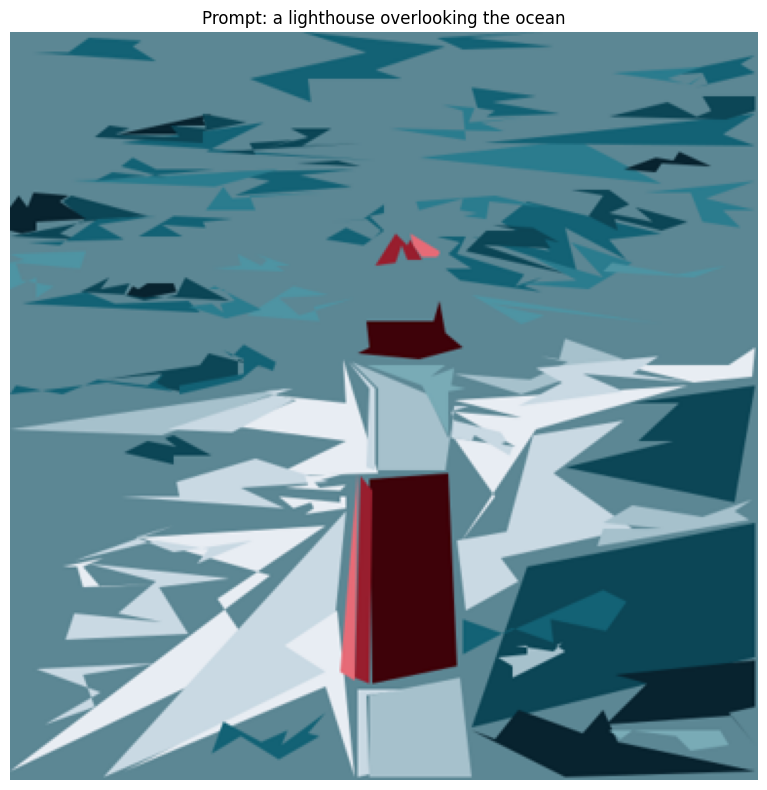

In [12]:
import subprocess
import psutil

def print_kaggle_memory_status():
    print("=== GPU Memory Usage ===")
    try:
        result = subprocess.run(['nvidia-smi'], stdout=subprocess.PIPE)
        print(result.stdout.decode())
    except Exception as e:
        print("Failed to get GPU memory info:", e)

    print("\n=== CPU Memory Usage ===")
    try:
        virtual_mem = psutil.virtual_memory()
        print(f"Used: {virtual_mem.used / 1024**3:.2f} GB / Total: {virtual_mem.total / 1024**3:.2f} GB")
    except Exception as e:
        print("Failed to get CPU memory info:", e)
        
# Read the CSV file
df = pd.read_csv('/kaggle/input/drawing-with-llms/train.csv')

# uncomment to test on just a few
df = df.head(3)

# Initialize the model
model = Model()

for i, row in enumerate(df.iterrows()):
    # print_kaggle_memory_status()
    description = row[1]['description']
    
    # Generate image from description
    svg = model.predict(description)
    rendered_img = svg_to_png(svg)
        
    # Display the image being processed
    plt.figure(figsize=(10, 8))
    plt.imshow(rendered_img)
    plt.title(f"Prompt: {description}")
    plt.axis('off')
    plt.tight_layout()
    plt.show()

## Extra Test

In [13]:
svg_val_path = kagglehub.dataset_download('raresbarbantan/draw-svg-validation')
val_df = pd.read_csv(f'{svg_val_path}/validation.csv')
val_df = val_df.groupby('id').apply(lambda df: df.to_dict(orient='list'), include_groups=False)
val_df = val_df.reset_index(name='qa')
val_df['description'] = val_df.qa.apply(lambda qa: qa['description'][0])
val_df = val_df.drop("qa", axis=1)
val_df = val_df.head(5)
val_df.head()

,id,description
0,0768ef,a bowl of fresh blueberries
1,0948d4,a dark olive green velvet armchair
2,0a0adb,a wooden rocking horse with a red saddle
3,0a3c71,golden retriever puppy sitting in a basket
4,0e9acc,a chartreuse geometric pattern


  0%|          | 0/25 [00:00<?, ?it/s]

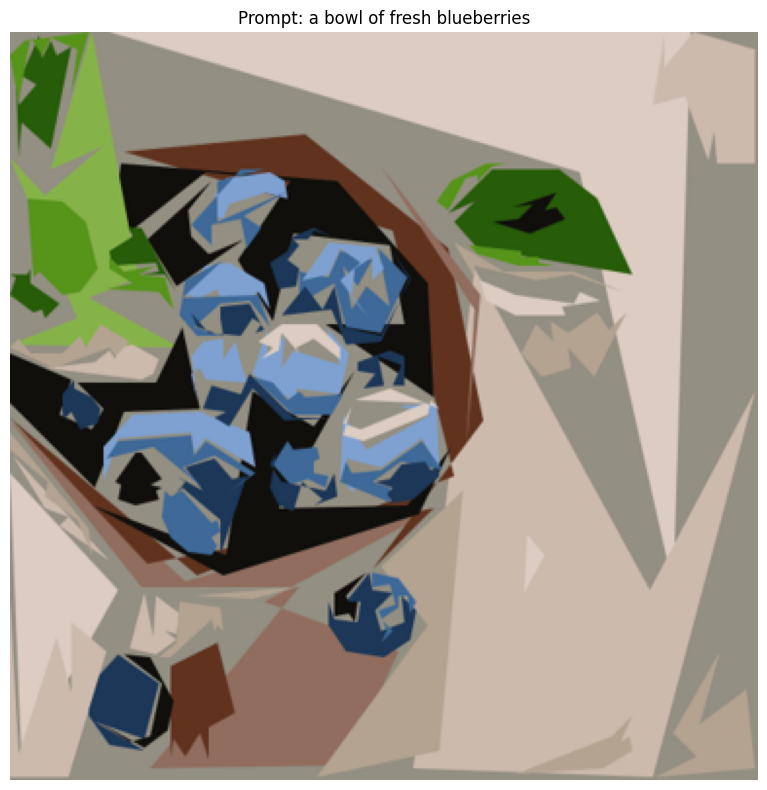

  0%|          | 0/25 [00:00<?, ?it/s]

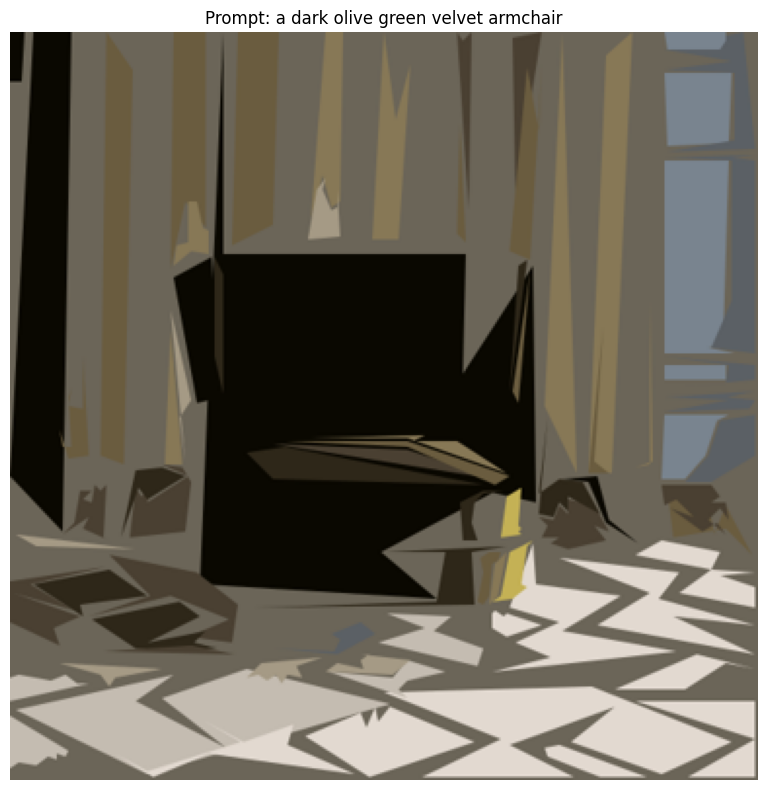

  0%|          | 0/25 [00:00<?, ?it/s]

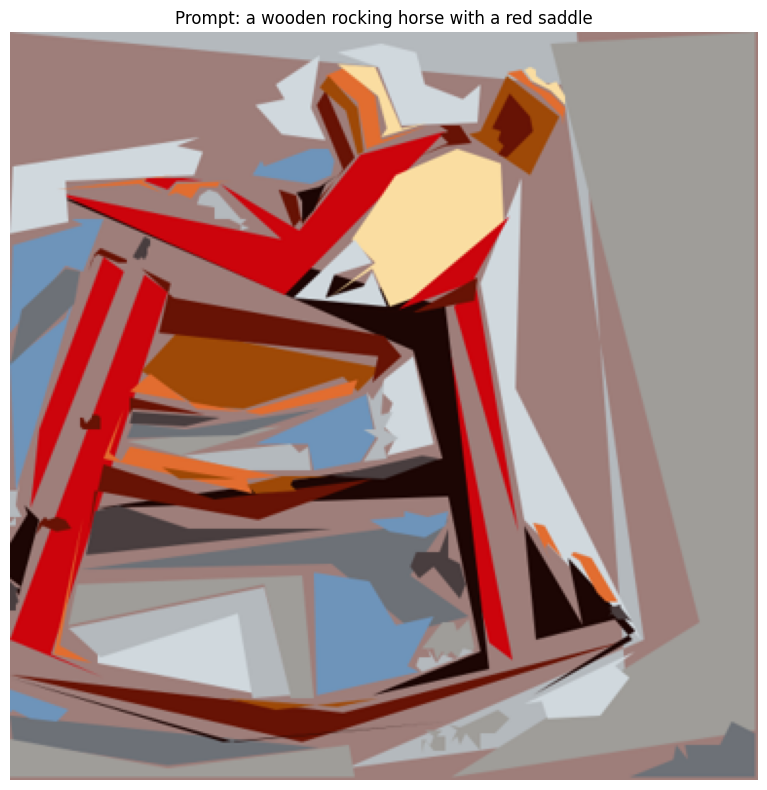

  0%|          | 0/25 [00:00<?, ?it/s]

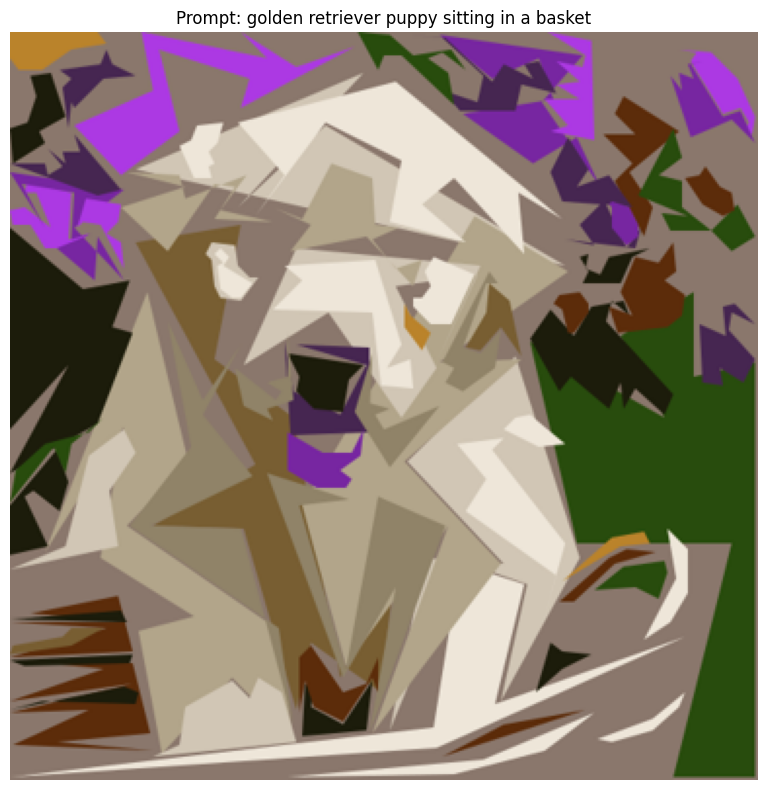

  0%|          | 0/25 [00:00<?, ?it/s]

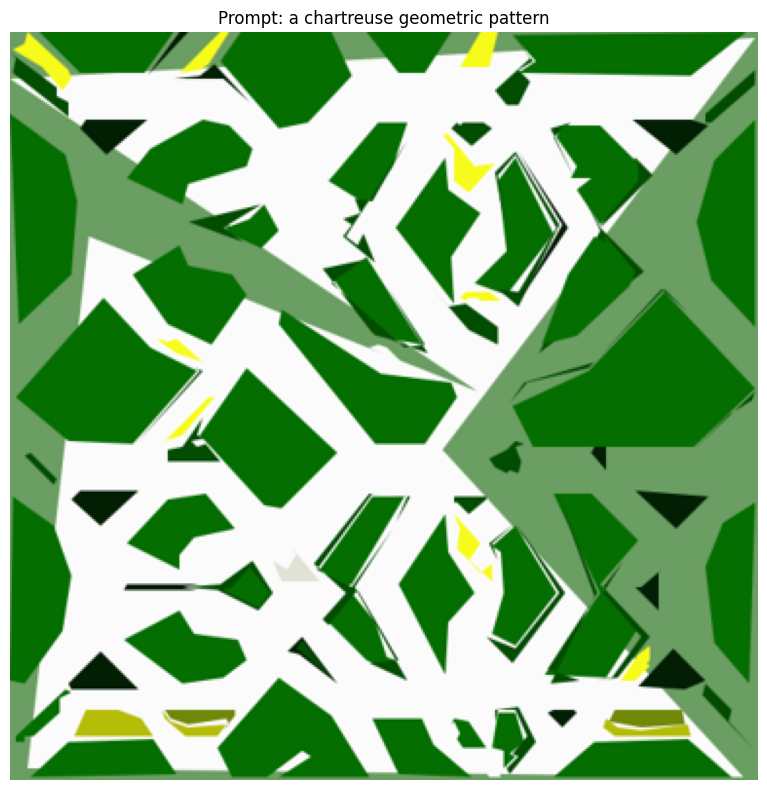

In [14]:
for i, row in enumerate(val_df.iterrows()):
    # print_kaggle_memory_status()
    description = row[1]['description']
    
    # Generate image from description
    svg = model.predict(description)
    rendered_img = svg_to_png(svg)
        
    # Display the image being processed
    plt.figure(figsize=(10, 8))
    plt.imshow(rendered_img)
    plt.title(f"Prompt: {description}")
    plt.axis('off')
    plt.tight_layout()
    plt.show()